In [20]:
import pandas as pd
import math
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy

In [21]:
def pi_l(p, vs, i, dist, supp):
    """lower bound for profits"""
    return vs*dist.cdf(p)**i + p*(1-dist.cdf(p)**i)


def pi_u(p, vs, i, dist, supp):
    """upper bound for profits"""
    integrand = lambda v: i*(i-1)*(1-dist.cdf(v))*v*dist.cdf(v)**(i-2)*dist.pdf(v)
    surplus = []
    for q in p:
        
        surplus.append( scipy.integrate.quad(integrand, q, supp[1])[0] )
    baseline = vs*dist.cdf(p)**i + i*p*(1-dist.cdf(p))*dist.cdf(p)**(i-1)
    return baseline + np.array(surplus)


obj = lambda p: -1*pi_u(p,.2,4,scipy.stats.uniform, (0,1))
print scipy.optimize.minimize(obj,[.2],method = 'Nelder-Mead')

 final_simplex: (array([[0.6       ],
       [0.59992188]]), array([-0.631104  , -0.63110399]))
           fun: -0.631104
       message: 'Optimization terminated successfully.'
          nfev: 32
           nit: 16
        status: 0
       success: True
             x: array([0.6])


(21,)
(21,)


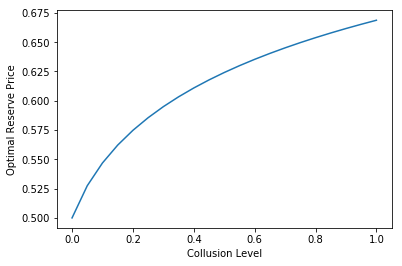

In [22]:
def pi_helper(q, vs, i, dist, supp):
    """argmax of lower bound"""
    obj = lambda p: -q*pi_l(p, vs, i, dist, supp) - (1-q)*pi_u(p, vs, i, dist, supp)
    result = scipy.optimize.minimize(obj, sum(supp)/2.)
    return result.x, -1*obj(result.x)

qs = np.arange(0,1.05,.05)
ps = [] 
for q in qs:
    pq = pi_helper(q, 0.,4., scipy.stats.uniform, (0.,1.))
    ps.append(pq[0][0])
ps = np.array(ps)
    
print qs.shape
print ps.shape

plt.plot(qs,ps)
plt.xlabel('Collusion Level')
plt.ylabel('Optimal Reserve Price')
plt.show()

In [23]:
#slightly different formulation of the problem

def pi_l2(p, vs, i, dist, supp):
    """lower bound for profits"""
    return i*(p-vs)*(1-dist.cdf(p))*dist.cdf(p)**(i-1)


def pi_u2(p, vs, i, dist, supp):
    """upper bound for profits"""
    integrand = lambda v: i*(i-1)*(1-dist.cdf(v))*v*dist.cdf(v)**(i-2)*dist.pdf(v)
    surplus = []
    for q in p:
        surplus.append( scipy.integrate.quad(integrand, q, supp[1])[0] )
    return pi_l2(p, vs, i, dist, supp) + np.array(surplus)


obj = lambda p: -1*pi_u2(p,.2,4,scipy.stats.uniform, (0,1))
#print scipy.optimize.minimize(obj,[.1],method = 'Nelder-Mead')

print obj(np.array([.6])),obj(np.array([.1]))

[-0.536064] [-0.599364]


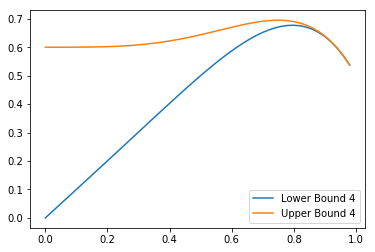

In [24]:
#overall bounds on profit
support = np.arange(.00,1.0,.02)
ub = pi_u(support, .5, 4, scipy.stats.uniform, (0,1))

lb = pi_l(support, .5, 4, scipy.stats.uniform, (0,1))


plt.plot(support, lb, label='Lower Bound 4')
plt.plot(support, ub, label='Upper Bound 4')
plt.legend()
plt.show()

In [29]:
def pi_opt(vs, i, dist, supp):
    """argmax of lower bound"""
    obj = lambda p: -pi_l(p, vs, i, dist, supp)
    result = scipy.optimize.minimize(obj, sum(supp)/2.)
    return result.x, -1*obj(result.x)


def pi_est(vs, i, dist, supp):
    """calculate the """
    argmax, maxim = pi_opt(vs, i, dist, supp)
   
    obj = lambda p:(pi_u(p, vs, i, dist, supp) - maxim)**2

    bnds1 = [(supp[0],argmax)]
    result1 = scipy.optimize.minimize(obj, argmax*.9, bounds=bnds1 )
    
    bnds2 = [(argmax,supp[1])]
    result2 = scipy.optimize.minimize(obj, argmax*1.1, bounds=bnds2 )

    return np.concatenate([result1.x, result2.x])

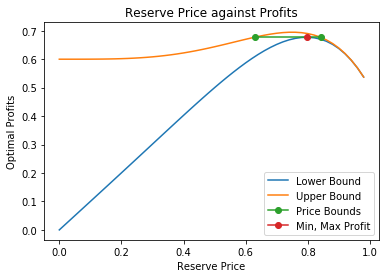

In [30]:
ub= pi_u(support, .5, 4, scipy.stats.uniform, (0,1))
lb = pi_l(support, .5, 4, scipy.stats.uniform, (0,1))

plt.plot(support, lb, label='Lower Bound')
plt.plot(support, ub, label='Upper Bound')


#bounds on reserve price
argmax, maxim = pi_opt(.5, 4, scipy.stats.uniform, (0,1))
p_bnds = pi_est(.5, 4, scipy.stats.uniform, (0,1))
#pi_bnds = pi_u(p_bnds, 0, 7, scipy.stats.uniform, (0,1))

plt.plot(p_bnds, np.tile(maxim,2), label='Price Bounds',marker='o')
plt.plot(argmax, maxim, label='Min, Max Profit',marker='o')


#make it pretty
plt.xlabel('Reserve Price')
plt.ylabel('Optimal Profits')
plt.title('Reserve Price against Profits')
plt.legend()
plt.show()